In [92]:
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
import matplotlib.pyplot as plt

from torch.autograd.functional import jacobian
from torch import tensor
import torch
import control
import scipy.linalg as sp_linalg

In [113]:
# System Description
# def f_tensor(x_tensor, u_tensor):
#     y0 = torch.sin(x_tensor[0]) - u_tensor[0] * torch.cos(x_tensor[1])
#     y1 = 2 * torch.cos(x_tensor[0]) * torch.sin(x_tensor[1])
#     return (y0,y1)

def f_tensor(x_tensor, u_tensor):
    y0 = torch.sin(x_tensor[0]) + u_tensor[0]
    y1 = x_tensor[1] + u_tensor[1]
    return (y0,y1)

def f(x, u):
    x_tensor = tensor(x)
    u_tensor = tensor(u)
    y0, y1 = f_tensor(x_tensor, u_tensor)
    y = np.array([[y0.item()], [y1.item()]])
    return y

def jacob(x, u):
    x_tensor = tensor(x)
    u_tensor = tensor(u)
    dy0dxdu, dy1dxdu = jacobian(f_tensor,(x_tensor, u_tensor))
    dy0dx, dy1dx = dy0dxdu[0], dy1dxdu[0]
    dy0du, dy1du = dy0dxdu[1], dy1dxdu[1]
    Jx = np.row_stack([dy0dx.numpy()[0].T, dy1dx.numpy()[0].T])
    Ju = np.row_stack([dy0du.numpy()[0].T, dy1du.numpy()[0].T])
    return Jx, Ju

In [114]:
Jx, Ju = jacob(x, u)
Ju

array([[1., 0.],
       [0., 1.]])

In [115]:
Jx

array([[0.9940047, 0.       ],
       [0.       , 1.       ]])

In [116]:
f(x,u)

array([[-0.10933738],
       [ 0.73908513]])

In [117]:
Jx, Ju = jacob(x, u)
Jx @ x + Ju @ u

array([[-0.10889958],
       [ 0.73908513]])

In [118]:
x

array([[-0.10955641],
       [ 0.73908513]])

In [108]:
u

array([[0.],
       [0.]])

In [120]:
n = 2 # state vector size
m = 2 # control size
p = 1 # output vector size
c = np.array([[-0.12, 0.06]]) # read-out matrix

T = np.arange(0, 100)  # Time points for simulation
x0 = np.array([[-3.0], [3.0]])

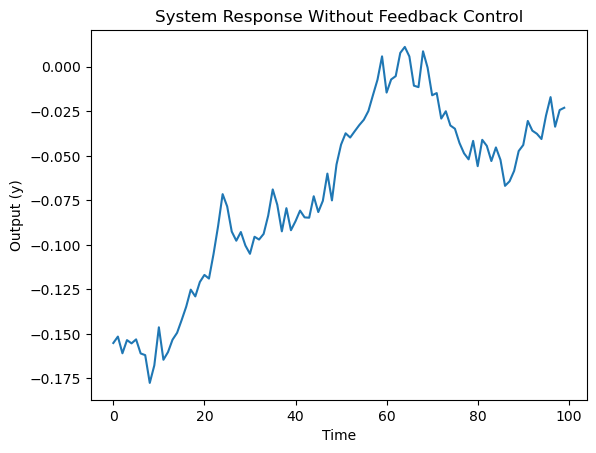

In [137]:
# Simulation Without Control
x = x0.copy()
u = np.array([[0.0], [0.0]])
xs = []
ys = []

# process noise
Bnoise = np.eye(n)  # Process noise enters directly on states
W = 0.0001 * np.eye(n)  # Process noise weight

for i in T:
    
    # update x
    process_noise = mvnrnd(np.zeros(n), W).reshape(-1,1)
    x1 = f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # output
    y = c @ x
    
    # save
    xs.append(x)
    ys.append(y.item())

# Plot the output 'ys'
x1s = [x[0].item() for x in xs]
# lt.plot(T, ys)
plt.plot(T, x1s)
plt.xlabel('Time')
plt.ylabel('Output (y)')
plt.title('System Response Without Feedback Control')
plt.show()

### Non-linear LQR

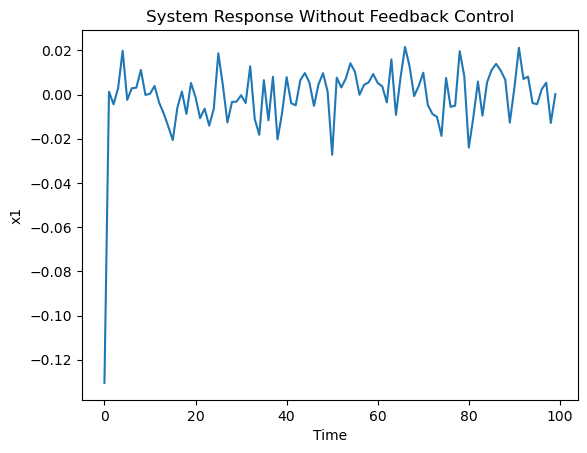

In [134]:
# Design Kalman Filter
Bnoise = np.eye(n)  # Process noise enters directly on states
Q = np.eye(n)  # Weight on state feedback
R = 0.001 * np.eye(m)  # Input weight
W = 0.0001 * np.eye(n)  # Process noise weight
# V = 0.0001 * np.eye(m)  # Measurement noise weight

x = x0.copy()
xhat = x0.copy()
Phat = W.copy()
u = np.array([[0.0], [0.0]])
xs = []
ys = []
for i in T:

    # Update x
    process_noise = mvnrnd(np.zeros(n), W).reshape(-1,1)
    x1 = f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # Output
    y = c @ x

    # Save
    xs.append(x)
    ys.append(y.item())

    # LQR
    A, B = jacob(x, u)
    X = sp_linalg.solve_discrete_are(A, B, Q, R)
    K = np.dot(np.linalg.pinv(R + np.dot(B.T, np.dot(X, B))), np.dot(B.T, np.dot(X, A)))
    # K, _, _ = control.lqr(Fx-np.eye(n), Fu, Q, R)
    u = -K @ x
    # print(u)

# Plot the state
x1s = [x[0].item() for x in xs]
# lt.plot(T, ys)
plt.plot(T, x1s)
# plt.plot(T, yress)
plt.xlabel('Time')
plt.ylabel('x1')
plt.title('System Response Without Feedback Control')
plt.show()

In [129]:
u

array([[ 4.01939178e-108],
       [-7.97714934e-107]])

In [127]:
A

array([[1., 0.],
       [0., 1.]])

In [128]:
B

array([[1., 0.],
       [0., 1.]])